# Test Run 9: Visualize the Capability of the Generative Model

This notebook continues from test run 8, and

1. visualize the current capability of the generative model for Purpose and Mechanism by their label distribution. 

Sometimes accessing the elements within a csr_LabelMatrix will throw exception. We don't know why yet. But we suggest to re-run from `L_train = labeler.apply(split=0)`, if that happens.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
debug_mode=1 # if not in debug mode, please set debug_mode=0
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

### Section 1: Loading documents and train/dev/test segments. 

#### The following two celsl should load in 8014 papers if they haven't been loaded. 

In [57]:
from snorkel import SnorkelSession
from snorkel.parser import TSVDocPreprocessor
session = SnorkelSession()

# # Here, we just set how many documents we'll process for automatic testing- you can safely ignore this!
n_docs = 9000 # this is the upper limit of number of docs
doc_preprocessor = TSVDocPreprocessor('data/70kpaper_061418_cleaned_noBookLecture_10cscw_2k_order_preserving.tsv', encoding="utf-8",max_docs=n_docs)

In [58]:
from snorkel import SnorkelSession
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser
from snorkel.models import Document, Sentence

session = SnorkelSession()
print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

docs = session.query(Document).all()
sents = session.query(Sentence).all()  # get all sentences from snorkel.db
n_max_corpus=0
for sent in sents:
    n_max_corpus=max(n_max_corpus,len(sent.words))
print("The longest sentence has "+str(n_max_corpus)+" tokens.")

train_sents = set()
dev_sents   = set()
test_sents  = set()

dev_doc_set = set()
test_doc_set = set()
for i, doc in enumerate(docs):
    for s in doc.sentences:
        if doc.name[:7]=="2K_dev_":
            dev_sents.add(s)
            dev_doc_set.add(doc.name)
        elif doc.name[:8]=="2K_test_":
            test_sents.add(s)
            test_doc_set.add(doc.name)
        else:
            train_sents.add(s)
print("dev_doc_set length",len(dev_doc_set))
print("dev_sents length", len(dev_sents),"dev_doc_set size", len(dev_doc_set), "avg n_sent per doc","%.3f"%(float(len(dev_sents))/float(len(dev_doc_set))))
print("test_doc_set length",len(test_doc_set))
print("test_sents length", len(test_sents),"test_doc_set size", len(test_doc_set), "avg n_sent per doc","%.3f"%(float(len(test_sents))/float(len(test_doc_set))))

Documents: 8014
Sentences: 24281
The longest sentence has 563 tokens.
dev_doc_set length 383
dev_sents length 835 dev_doc_set size 383 avg n_sent per doc 2.180
test_doc_set length 2071
test_sents length 4566 test_doc_set size 2071 avg n_sent per doc 2.205


In [4]:
from snorkel.models import candidate_subclass
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import *

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    

def extract_and_display(matcher,candidate_class,candidate_class_name,train_breakdown_map=None,dev_doc_breakdown_map=None,selected_split=0,is_print=True):  # split over train/dev/test but returns only train set
#     input(candidate_class)
    for (i, sents) in ([(0,train_sents), (1,dev_sents), (2,test_sents)] if selected_split==0 else ([(2,test_sents)] if selected_split==2 else [(1,dev_sents)])):
        %time matcher.apply(sents, split=i)
        printmd("**Split "+str(i)+" - number of candidates extracted: "+str(session.query(candidate_class).filter(candidate_class.split == i).count())+"**\n\n")
    train_cands = session.query(candidate_class).filter(candidate_class.split == selected_split).all()
    if is_print:
        for i in range(min(4,len(train_cands))): # to print at most 4 cands 
            printmd("**"+str(i)+"/"+str(len(train_cands))+" Candidate/Span:**\t`"+str(train_cands[i])+"`")
            printmd("**Its parent Sentence's text:**\t"+str(train_cands[i].get_parent().text))
            printmd("**Its parent Document's text:**\t"+str(train_cands[i].get_parent().get_parent().__dict__))
            print() 
        
    for cand in train_cands:
        doc_name=cand.get_parent().get_parent().name
        if doc_name not in train_breakdown_map:
            train_breakdown_map[doc_name]=dict()
        if candidate_class_name not in train_breakdown_map[doc_name]:
            train_breakdown_map[doc_name][candidate_class_name]=[]
        train_breakdown_map[doc_name][candidate_class_name]+=[cand]
        
    dev_cands = session.query(candidate_class).filter(candidate_class.split == 1).all()
    for cand in dev_cands:
        doc_name=cand.get_parent().get_parent().name
        if doc_name not in dev_doc_breakdown_map:
            dev_doc_breakdown_map[doc_name]=dict()
        if candidate_class_name not in dev_doc_breakdown_map[doc_name]:
            dev_doc_breakdown_map[doc_name][candidate_class_name]=[]
        dev_doc_breakdown_map[doc_name][candidate_class_name]+=[cand]
    test_cands=session.query(candidate_class).filter(candidate_class.split==2).all()
    
    return train_cands,dev_cands,test_cands

Segment = candidate_subclass('Segment', ['segment_cue'])
ngrams = Ngrams(n_max=n_max_corpus) 
non_tilde_matcher=DictionaryMatch(d=['~'],longest_match_only=True,reverse=True)  
non_tilde_segment_extractor=CandidateExtractor(Segment, [ngrams], [non_tilde_matcher])
train_doc_breakdown_map=dict()
dev_doc_breakdown_map=dict()

# train_segments,dev_segments,test_segments=extract_and_display(non_tilde_segment_extractor,Segment,"Segment",train_doc_breakdown_map,dev_doc_breakdown_map,is_print=False)
train_segments=session.query(Segment).filter(Segment.split == 0).all()
print(len(train_segments))
dev_segments=session.query(Segment).filter(Segment.split == 1).all()
test_segments=session.query(Segment).filter(Segment.split == 2).all()

18911


### Section 2 Evaluate with a small dev set of groundtruth

The steps are:

1. Load gold labels in matrix format, from this file
2. Evaluate LFs with this gold label matrix

In [5]:
# current_level=1
# current_docid_prefix="2K_dev"

from util import load_groundtruth_as_external_dict
from util import write_segment_name 
from util import load_external_labels
from snorkel.annotations import load_gold_labels
import re
from snorkel.lf_helpers import *

# groundtruth_dict=load_groundtruth_as_external_dict("data/annotations_label-level_all-to-date-2018-4-25-WithTitle.labelled.originalSegments_level_"+str(current_level)+".csv",delimiter=",")
# printmd("**Take a random example doc, what segments does it have<br /><br />** "+str(groundtruth_dict[list(groundtruth_dict.keys())[10]]))

purpose_gold_path="data/purpose_gold_dev_testrun_8.tsv"                       
# write_segment_name(dev_segments,purpose_gold_path,groundtruth_dict,segment_name="Purpose")   
%time external_purpose = load_external_labels(session, Segment, annotator_name='purpose_dev_gold',isPrint=False,file_path=purpose_gold_path)
L_gold_dev = load_gold_labels(session, annotator_name='purpose_dev_gold', split=1)
print((L_gold_dev).shape)
print("\n")

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


AnnotatorLabels newly created: 0
AnnotatorLabels newly created: 0
CPU times: user 31.3 s, sys: 967 ms, total: 32.3 s
Wall time: 34.2 s
(3834, 1)




#### Iterate and tuning more LFs based on dev set 

Example:

    def LF_toy(c):
        return -1 if len(str(c))>10 else 0   # this heuristic has no actual meaning  
        tp, fp, tn, fn = test_LF(session, LF_toy, split=1, annotator_name='purpose_dev',test_labels=L_gold_dev)
        
Output example: 

    test_candidates # 6006
    test_marginals [0.5 0.5 0.5 ... 0.5 0.5 0.5]
    ========================================
    Scores (Un-adjusted)
    ========================================
    Pos. class recall: 0.0
    Neg. class recall: 1.0
    Precision            0.0
    Recall               0.0
    F1                   0.0
    ----------------------------------------
    TP: 0 | FP: 0 | TN: 88 | FN: 5
    ========================================


#### Loading more realistic LFs in aggregation, train a generative model, evaluate the model on dev set

1. `L_purpose_train.lf_stats(session)` reports coverage, overlaps, and conflicts, which are self-evaluation. 

2. Note the difference between `learned accuracy` and `empirical accuracy`.

    <b>Our understanding based on code:</b>

    1. Learned accuracy is evaluating each LF <b>w.r.t. trained generative model output as groundtruth</b>

    2. Empirical accuracy is evaluating each LF <b>w.r.t. gold label</b>

In [10]:
from snorkel.lf_helpers import *
from snorkel.annotations import LabelAnnotator
from LF.util_purpose_default import common_LFs,purpose_LFs,neg_for_purpose_LFs   # neg_LFs are reverse LFs for Background, Mechanism, Method, and Finding

print("common_LFs",len(common_LFs))
print("purpose_LFs",len(purpose_LFs))
print("neg_for_purpose_LFs",len(neg_for_purpose_LFs)) # 39 mechanism, 35 background, 24 findings

common_LFs 8
purpose_LFs 74
neg_for_purpose_LFs 112


We also report <b>Total Coverage</b>: Coverage that corrected from Overlaps and Conflicts, essentially # candidates that are labelled by at least one LF / # total candidates. We also did a quick sanity check to ensure this number is calculated correctly, see [`data/calculate_total_coverage_toy_test_for_test_run_8.xlsx`](data/calculate_total_coverage_toy_test_for_test_run_8.xlsx).

In [11]:
from snorkel.lf_helpers import *
from snorkel.annotations import LabelAnnotator

np.random.seed(1702)
labeler = LabelAnnotator(lfs=common_LFs+purpose_LFs+neg_for_purpose_LFs)
%time L_dev = labeler.apply(split=1)
printmd("**Total non_overlapping_coverage (percentage of labelled over all)**  "+str(L_dev.non_overlapping_coverage()))
printmd("**Total empirical recall (percentage of at least once True Positives over Positives)**  "+str(L_dev.total_empirical_recall(L_gold_dev)))
L_dev.lf_stats(session, L_gold_dev,set_unlabeled_as_neg=True,csv_path="data/L_dev_purpose_for_coverage_most_recent.csv")

cids_count 3834
key_group 0
Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 20s, sys: 702 ms, total: 1min 21s
Wall time: 1min 23s


**Total non_overlapping_coverage (percentage of labelled over all)**  1.0

positive segments in gold labels 860 out of 3834
sum over rows shape (3834, 1)
TP over all segments 761
P among all segments 860


**Total empirical recall (percentage of at least once True Positives over Positives)**  0.8848837209302326

/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:214: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Empirical Recall.
LF_common_s_however,0,0.014867,0.014867,0.012259,45,12,815,2957,0.784017,0.052326
LF_common_s_nevertheless,1,0.000782,0.000782,0.000522,0,3,860,2966,0.774615,0.000000
LF_common_s_despite,2,0.003391,0.003391,0.002608,3,10,857,2959,0.773570,0.003488
LF_common_s_spite,3,0.000782,0.000782,0.000782,1,2,859,2967,0.775137,0.001163
LF_common_s_yet,4,0.004956,0.004956,0.004173,5,14,855,2955,0.773048,0.005814
LF_common_s_but,5,0.020866,0.020866,0.019823,10,70,850,2899,0.759728,0.011628
LF_common_but_sometimes,6,0.000261,0.000261,0.000261,0,0,860,2969,0.775398,0.000000
LF_common_but_also,7,0.001304,0.001304,0.001304,0,0,860,2969,0.775398,0.000000
LF_purpose_more_a_z_than,8,0.002869,0.002869,0.002869,1,10,859,2959,0.773048,0.001163
LF_purpose_er_than,9,0.012780,0.012780,0.012780,3,46,857,2923,0.764168,0.003488


In [12]:
from snorkel.learning import GenerativeModel
np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train
printmd("**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  "+str(L_train.non_overlapping_coverage()))
gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0)

print("Finished training generative model, now checking performance against development set labels...")



cids_count 18911
key_group 0
Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 6min 7s, sys: 1.02 s, total: 6min 8s
Wall time: 6min 9s


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  1.0

Inferred cardinality: 2
Finished training generative model, now checking performance against development set labels...


In [15]:
np.random.seed(1701)
%time L_dev = labeler.apply_existing(split=1)

_ = gen_model.error_analysis(session, L_dev, L_gold_dev,set_unlabeled_as_neg=True)

L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'],set_unlabeled_as_neg=True)

cids_count 3834
key_group 0
Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 51s, sys: 660 ms, total: 1min 52s
Wall time: 1min 58s
Scores (Un-adjusted)
Pos. class recall: 0.551
Neg. class recall: 0.676
Precision            0.329
Recall               0.551
F1                   0.412
----------------------------------------
TP: 474 | FP: 965 | TN: 2009 | FN: 386

cardinality is 2


/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:214: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Empirical Recall.,Learned Metric.
LF_common_s_however,0,0.014867,0.009911,0.002608,45,12,815,2957,0.784017,0.052326,0.570696
LF_common_s_nevertheless,1,0.000782,0.000522,0.000261,0,3,860,2966,0.774615,0.000000,0.558961
LF_common_s_despite,2,0.003391,0.002608,0.001043,3,10,857,2959,0.773570,0.003488,0.556020
LF_common_s_spite,3,0.000782,0.000261,0.000000,1,2,859,2967,0.775137,0.001163,0.555422
LF_common_s_yet,4,0.004956,0.003391,0.002087,5,14,855,2955,0.773048,0.005814,0.574994
LF_common_s_but,5,0.020866,0.015389,0.007303,10,70,850,2899,0.759728,0.011628,0.563316
LF_common_but_sometimes,6,0.000261,0.000261,0.000261,0,0,860,2969,0.775398,0.000000,0.554277
LF_common_but_also,7,0.001304,0.001304,0.001304,0,0,860,2969,0.775398,0.000000,0.567547
LF_purpose_more_than,8,0.007825,0.004434,0.002608,2,28,858,2941,0.768608,0.002326,0.560194
LF_purpose_er_than,9,0.012780,0.008607,0.006260,3,46,857,2923,0.764168,0.003488,0.559683


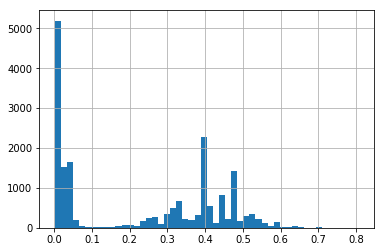

In [13]:
train_marginals = gen_model.marginals(L_train)  # the marginal probability of each candidate being True
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=50)
plt.grid()
plt.show()

In [67]:
from util import get_candidate_text
train_marginals_list=list(train_marginals)
# print(train_marginals_list)
# print(train_marginals)

print(len(train_segments))
# print(train_marginals_list)
zipped=zip(train_segments,train_marginals_list)
pairs=[pair for pair in zipped]
# print("above 0.15 has "+str(len([pair for pair in pairs if pair[1]>=0.4])))
sorted_pairs=sorted(pairs,key=lambda x: x[1],reverse=True)

f_write=open("data/ranked_high_to_low_generative_purpose","w")
for element in sorted_pairs:
    try:
        f_write.write(get_candidate_text(element[0]).strip()+"\t"+str(element[1])+"\n")
    except:
        pass

18911


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  1.0

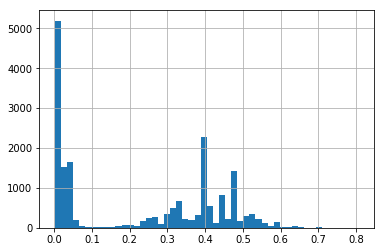

In [23]:
printmd("**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  "+str(L_train.non_overlapping_coverage()))
plt.hist(train_marginals, bins=50)
plt.grid()
plt.savefig("data/purpose_L_train_marginals_"+str(len(purpose_LFs))+str(len(neg_for_purpose_LFs)))


In [28]:
docid=194
print(train_segments[docid])
print(train_segments[docid].get_parent())
print(train_segments[docid].get_parent().__dict__)
print(train_segments[docid].get_parent().get_parent().sentences)
print(train_segments[docid].get_parent().get_parent().sentences.index(train_segments[docid].get_parent()))
# print(docs[1].sentences)

Segment(Span("b'Our current domain of study is the film preview (the commercial advertisements primarily created to attract audiences).'", sentence=11073, chars=[0,118], words=[0,19]))
Sentence(Document 5834868425ff05a97b00d6d6,2,b'Our current domain of study is the film preview (the commercial advertisements primarily created to attract audiences).')
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x112419828>, 'entity_cids': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], 'stable_id': '5834868425ff05a97b00d6d6::sentence:293:412', 'pos_tags': ['PRP$', 'JJ', 'NN', 'IN', 'NN', 'VBZ', 'DT', 'NN', 'NN', '-LRB-', 'DT', 'JJ', 'NNS', 'RB', 'VBN', 'TO', 'VB', 'NNS', '-RRB-', '.'], 'abs_char_offsets': [293, 297, 305, 312, 315, 321, 324, 328, 333, 341, 342, 346, 357, 372, 382, 390, 393, 401, 410, 411], 'dep_parents': [3, 3, 6, 3, 4, 0, 9, 9, 6, 9, 13, 13, 9, 15, 13, 17, 15, 17, 15, 6], 'char_offsets': [0, 4, 12, 19, 22, 